In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.utils import shuffle

class OptimizedDifferentiablePchip(nn.Module):
    def __init__(self, x_min, x_max, y_init, n_control_points):
        super().__init__()
        # Store min and max for the feature range
        self.x_min = x_min
        self.x_max = x_max
        self.n = n_control_points
        # Learnable parameters for x-coordinate increments
        self.theta = nn.Parameter(torch.zeros(n_control_points - 1))
        # Y-coordinates as learnable parameters
        self.y = nn.Parameter(y_init.clone().detach())
        self.d = None  # To store precomputed derivatives
        self.x = None  # To store computed x control points

    def update_spline(self):
        """Compute x control points and derivatives based on current parameters."""
        # Compute x coordinates parametrically
        delta = F.softplus(self.theta)  # Ensure positive increments
        cum_sum = torch.cumsum(torch.cat([torch.tensor([0.0], device=self.theta.device), delta]), dim=0)
        total_sum = cum_sum[-1]
        self.x = self.x_min + (self.x_max - self.x_min) * cum_sum / total_sum
        # Compute derivatives
        dy = self.y[1:] - self.y[:-1]
        dx = self.x[1:] - self.x[:-1]
        slopes = dy / dx
        d = torch.zeros_like(self.y)
        for i in range(1, len(self.y) - 1):
            if slopes[i - 1] * slopes[i] > 0:
                w1 = 2 * dx[i] + dx[i - 1]
                w2 = dx[i] + 2 * dx[i - 1]
                d[i] = (w1 + w2) / (w1 / slopes[i - 1] + w2 / slopes[i])
        d[0] = slopes[0]
        d[-1] = slopes[-1]
        self.d = d

    def forward(self, t):
        if self.x is None or self.d is None:
            self.update_spline()  # Ensure spline is updated
        t = t.contiguous()
        idx = torch.clamp(torch.searchsorted(self.x, t) - 1, 0, self.n - 2)
        x0 = self.x[idx]
        x1 = self.x[idx + 1]
        y0 = self.y[idx]
        y1 = self.y[idx + 1]
        t_norm = (t - x0) / (x1 - x0)
        d0 = self.d[idx]
        d1 = self.d[idx + 1]
        t2 = t_norm * t_norm
        t3 = t2 * t_norm
        h00 = 2 * t3 - 3 * t2 + 1
        h10 = t3 - 2 * t2 + t_norm
        h01 = -2 * t3 + 3 * t2
        h11 = t3 - t2
        dx_segment = x1 - x0
        return h00 * y0 + h10 * dx_segment * d0 + h01 * y1 + h11 * dx_segment * d1

class GradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, device=None, track_history=False, optimizer_type='adam',
                 scheduler_type='reduce_on_plateau'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.track_history = track_history
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type
        torch.manual_seed(random_state)
        np.random.seed(random_state)

    def _to_tensor(self, data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.to(self.device, dtype=dtype, non_blocking=True)
        return torch.tensor(data, dtype=dtype, device=self.device)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = torch.mean(X[mask_1], dim=0)
        self.m0 = torch.mean(X[~mask_1], dim=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        self.spline_models = nn.ModuleList()
        for i in range(n_features):
            x_min, x_max = X[:, i].min().item(), X[:, i].max().item()
            y_min, y_max = X[:, -1].min().item(), X[:, -1].max().item()
            y_mid = (self.m0[-1] + self.m1[-1]) / 2
            y_range = y_max - y_min
            control_y = torch.empty(self.n_control_points, device=self.device).uniform_(
                y_mid - y_range * 0.05, y_mid + y_range * 0.05
            )
            spline = OptimizedDifferentiablePchip(x_min, x_max, control_y, self.n_control_points).to(self.device)
            self.spline_models.append(spline)
        self.initial_control_points = [(m.x.clone() if m.x is not None else torch.linspace(x_min, x_max, self.n_control_points), m.y.clone()) for m in self.spline_models]

    def _calculate_displacement(self, X):
        total_spline = sum(spline(X[:, i]) for i, spline in enumerate(self.spline_models))
        return X[:, -1] - total_spline

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.unsqueeze(0))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return torch.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _create_optimizer_and_scheduler(self):
        params = [p for spline in self.spline_models for p in spline.parameters()]
        if self.optimizer_type.lower() == 'adam':
            optimizer = torch.optim.Adam(params, lr=self.initial_learning_rate)
        else:
            optimizer = torch.optim.SGD(params, lr=self.initial_learning_rate)
        if self.scheduler_type.lower() == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=self.decay_factor,
                patience=self.patience, min_lr=self.min_learning_rate)
        else:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=self.patience, gamma=self.decay_factor
            )
        return optimizer, scheduler

    def fit(self, X, y):
        try:
            l = np.unique(y)
            if len(l) != 2:
                raise ValueError("Algorithm for binary classification only.")
            if X.shape[1] < 2:
                raise ValueError("At least 2 features required")

            self.label_mapping = {l[0]: 0, l[1]: 1}
            y = np.where(y == l[0], 0, 1)

            X_tensor = self._to_tensor(X)
            y_tensor = self._to_tensor(y, dtype=torch.long)

            with torch.no_grad():
                self._calculate_class_means(X_tensor, y_tensor)
                self._initialize_control_points(X_tensor)

            optimizer, scheduler = self._create_optimizer_and_scheduler()

            best_error = float('inf')
            best_control_ys = [spline.y.clone() for spline in self.spline_models]
            best_class_1_pseudo = None

            if self.track_history:
                self.error_history_ = []
                self.control_point_history = [self.initial_control_points]

            for epoch in range(self.epochs):
                for spline in self.spline_models:
                    spline.update_spline()

                total_spline = sum(spline(X_tensor[:, i]) for i, spline in enumerate(self.spline_models))
                displacements = X_tensor[:, -1] - total_spline

                pseudo_labels = self._update_pseudo_labels(X_tensor, y_tensor)
                errors = displacements * pseudo_labels <= 0
                error_count = errors.sum().item()

                if self.verbose and epoch % 5 == 0:
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

                if error_count < best_error:
                    best_error = error_count
                    best_control_ys = [spline.y.clone() for spline in self.spline_models]
                    best_class_1_pseudo = self.class_1_pseudo
                    self.best_epoch = epoch
                    if error_count == 0 and epoch > 10:
                        if self.verbose:
                            print(f"Perfect separation achieved at epoch {epoch}")
                        break

                if self.track_history:
                    self.error_history_.append(error_count)
                    self.control_point_history.append(
                        [(s.x.clone().cpu().detach().numpy(), s.y.clone().detach().cpu().numpy())
                         for s in self.spline_models]
                    )

                if error_count == 0:
                    continue

                error_indices = torch.where(errors)[0]
                displacements_err = displacements[error_indices]
                y_err = y_tensor[error_indices]
                ti = torch.where(y_err == 1, 1, -1)
                loss = torch.mean(torch.relu(1.0 - ti * self.class_1_pseudo * displacements_err))

                if self.lambda_reg > 0:
                    smoothness_penalty = 0
                    for spline in self.spline_models:
                        y_diff = spline.y[1:] - spline.y[:-1]
                        x_diff = spline.x[1:] - spline.x[:-1]
                        smoothness_penalty += torch.mean((y_diff / (x_diff + 1e-8))**2)
                    loss += self.lambda_reg * smoothness_penalty

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

                if scheduler is not None:
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(error_count)
                    else:
                        scheduler.step()
                    if optimizer.param_groups[0]['lr'] <= self.min_learning_rate:
                        if self.verbose:
                            print(f"Minimum learning rate reached at epoch {epoch}")
                        break

            for spline, best_y in zip(self.spline_models, best_control_ys):
                spline.y.data = best_y
            self.class_1_pseudo = best_class_1_pseudo
        except Exception as e:
            print(f"Error in SMPA fit: {str(e)}", flush=True)
            import traceback
            traceback.print_exc(flush=True)
            raise
        return self

    def predict(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        predictions = torch.where(displacements > 0,
                                  torch.tensor(1 if self.class_1_pseudo > 0 else 0, device=self.device),
                                  torch.tensor(0 if self.class_1_pseudo > 0 else 1, device=self.device))
        pred_numpy = predictions.cpu().numpy()
        reverse_mapping = {v: k for k, v in self.label_mapping.items()}
        return np.array([reverse_mapping[p] for p in pred_numpy])

    def predict_proba(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        raw_probs = 1 / (1 + torch.exp(-displacements * 0.5))
        probs = torch.zeros(X.shape[0], 2, device=self.device)
        if self.class_1_pseudo > 0:
            probs[:, 1] = raw_probs
            probs[:, 0] = 1 - raw_probs
        else:
            probs[:, 0] = raw_probs
            probs[:, 1] = 1 - raw_probs
        return probs.cpu().detach().numpy()

In [2]:
import torch
import torch.nn as nn
import numpy as np

class SMPATransformer(nn.Module):
    def __init__(self, n_features, n_control_points=6, lambda_reg=0.1, device=None):
        super().__init__()
        self.n_features = n_features - 1
        self.n_control_points = n_control_points
        # Convert lambda_reg to float to handle string inputs
        try:
            self.lambda_reg = float(lambda_reg)
        except (TypeError, ValueError) as e:
            raise ValueError(f"lambda_reg must be convertible to float, got {lambda_reg} ({type(lambda_reg)})") from e
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.spline_models = nn.ModuleList()
        self.to(self.device)

    def initialize_from_smpa(self, smpa, X=None):
        self.spline_models = nn.ModuleList()
        for i in range(self.n_features):
            original_spline = smpa.spline_models[i]
            original_spline.update_spline()
            control_x = original_spline.x.detach().cpu().numpy()
            control_y = original_spline.y.detach().cpu().numpy()
            control_theta = original_spline.theta.detach().cpu().numpy()
            if X is not None:
                x_min, x_max = float(X[:, i].min()), float(X[:, i].max())
            else:
                x_min, x_max = float(original_spline.x_min), float(original_spline.x_max)
            x_tensor = torch.tensor(control_x, device=self.device, dtype=torch.float32)
            y_tensor = torch.tensor(control_y, device=self.device, dtype=torch.float32)
            theta_tensor = torch.tensor(control_theta, device=self.device, dtype=torch.float32)
            spline = OptimizedDifferentiablePchip(x_min=x_min, x_max=x_max,
                                                 y_init=y_tensor, n_control_points=self.n_control_points)
            spline.x = x_tensor
            spline.y = nn.Parameter(y_tensor, requires_grad=False)
            spline.theta = nn.Parameter(theta_tensor, requires_grad=False)
            spline.update_spline()
            self.spline_models.append(spline)

    def _to_tensor(self, data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.to(self.device, dtype=dtype, non_blocking=True)
        return torch.tensor(data, dtype=dtype, device=self.device)

    def _compute_linear_function(self, spline, X):
        """Compute linear function from spline's first and last control points."""
        x0, x1 = spline.x[0], spline.x[-1]
        y0, y1 = spline.y[0], spline.y[-1]
        m = (y1 - y0) / (x1 - x0 + 1e-8)  # Slope
        b = y0 - m * x0  # Intercept
        y_linear = m * X + b
        return y_linear

    def forward(self, X):
        X = self._to_tensor(X)
        total_adjustment = torch.zeros(X.shape[0], device=self.device)
        for i, spline in enumerate(self.spline_models):
            spline_output = spline(X[:, i])
            y_linear = self._compute_linear_function(spline, X[:, i])
            # Compute regularization factor based on smoothness penalty
            y_diff = spline.y[1:] - spline.y[:-1]
            x_diff = spline.x[1:] - spline.x[:-1]
            penalty = torch.mean((y_diff / (x_diff + 1e-8))**2)
            lambda_reg = torch.tensor(self.lambda_reg, device=self.device, dtype=torch.float32)
            reg_factor = 1 / (1 + lambda_reg * penalty)
            total_adjustment += reg_factor * (spline_output - y_linear)
        Z = X.clone()
        Z[:, -1] = X[:, -1] - total_adjustment
        return Z

    def compute_smoothness_penalty(self):
        smoothness_penalty = 0
        for spline in self.spline_models:
            y_diff = spline.y[1:] - spline.y[:-1]
            x_diff = spline.x[1:] - spline.x[:-1]
            penalty = torch.mean((y_diff / (x_diff + 1e-8))**2)
            smoothness_penalty += penalty
        return smoothness_penalty

In [3]:
class SMPAEndtoEnd(nn.Module):
    def __init__(self, n_features, n_control_points=6, classifier_type='linear', hidden_dim=16, device=None):
        super().__init__()
        self.transformer = SMPATransformer(n_features, n_control_points, 0.0001, device)
        if classifier_type == 'linear':
            self.classifier = nn.Linear(n_features, 1)
        elif classifier_type == 'mlp':
            self.classifier = nn.Sequential(
                nn.Linear(n_features, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
            )
        else:
            raise ValueError("Classifier must be 'linear' or 'mlp'")
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def initialize_from_smpa(self, smpa, X=None):
        self.transformer.initialize_from_smpa(smpa, X)

    def forward(self, X):
        Z = self.transformer(X).detach()  # Approach 2: Fixed splines
        logits = self.classifier(Z)
        return logits

    def compute_smoothness_penalty(self):
        return self.transformer.compute_smoothness_penalty()

    def predict_proba(self, X):
        logits = self.forward(X)
        probs = torch.sigmoid(logits)
        return torch.cat([1 - probs, probs], dim=1)

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs[:, 1] > 0.5).long()

def train_smpa_end_to_end(X, y, n_control_points=6, classifier_type='linear', smpa_epochs=200,
                         finetune_epochs=100, learning_rate=0.05, batch_size=32, verbose=False):
    smpa = GradientSMPA(
        n_control_points=n_control_points,
        learning_rate=learning_rate,
        epochs=smpa_epochs,
        verbose=verbose,
        random_state=7
    )
    smpa.fit(X, y)

    n_features = X.shape[1]
    model = SMPAEndtoEnd(
        n_features=n_features,
        n_control_points=n_control_points,
        classifier_type=classifier_type,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    model.initialize_from_smpa(smpa, X=X)

    X_tensor = torch.tensor(X, dtype=torch.float32, device=model.device)
    y_tensor = torch.tensor(y, dtype=torch.float32, device=model.device).view(-1, 1)
    dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    best_loss = float('inf')
    best_state = None

    for epoch in range(finetune_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = F.binary_cross_entropy_with_logits(logits, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        epoch_loss /= len(X_tensor)
        if verbose and epoch % 10 == 0:
            print(f"Fine-tune Epoch {epoch}, Loss: {epoch_loss:.4f}")
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)
    return model, smpa

In [21]:
sonar_df = pd.read_csv("./Dataset_Benchmarking/Datasets/sonar.csv", header = None)
num_features = sonar_df.shape[1] - 1  # Assuming the last column is the label
feature_names = [f'feature{i+1}' for i in range(num_features)] + ['label']
sonar_df.columns = feature_names
dict1 = {'R':0,'M':1}
sonar_df = sonar_df.replace({'label':dict1})
sonar_df['label'] = sonar_df['label'].apply(pd.to_numeric, errors = 'coerce')
sonar_df = shuffle(sonar_df, random_state=42)

train_df, test_df = train_test_split(sonar_df, test_size = 0.2, random_state = 22)
X_train = train_df.drop("label", axis = 1)
y_train = train_df["label"]
X_test = test_df.drop("label", axis = 1)
y_test = test_df["label"]

/tmp/ipykernel_61518/506893241.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sonar_df = sonar_df.replace({'label':dict1})


In [22]:
sonar_df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,label
161,0.0305,0.0363,0.0214,0.0227,0.0456,0.0665,0.0939,0.0972,0.2535,0.3127,...,0.0200,0.0070,0.0070,0.0086,0.0089,0.0074,0.0042,0.0055,0.0021,1
15,0.0298,0.0615,0.0650,0.0921,0.1615,0.2294,0.2176,0.2033,0.1459,0.0852,...,0.0031,0.0153,0.0071,0.0212,0.0076,0.0152,0.0049,0.0200,0.0073,0
73,0.0139,0.0222,0.0089,0.0108,0.0215,0.0136,0.0659,0.0954,0.0786,0.1015,...,0.0062,0.0072,0.0113,0.0012,0.0022,0.0025,0.0059,0.0039,0.0048,0
96,0.0181,0.0146,0.0026,0.0141,0.0421,0.0473,0.0361,0.0741,0.1398,0.1045,...,0.0223,0.0255,0.0145,0.0233,0.0041,0.0018,0.0048,0.0089,0.0085,0
166,0.0411,0.0277,0.0604,0.0525,0.0489,0.0385,0.0611,0.1117,0.1237,0.2300,...,0.0217,0.0038,0.0019,0.0065,0.0132,0.0108,0.0050,0.0085,0.0044,1


In [23]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [24]:
model, smpa = train_smpa_end_to_end(
    X_train,
    y_train,
    n_control_points=6,
    classifier_type='linear',
    smpa_epochs=350,
    finetune_epochs=100,
    learning_rate=0.4,
    batch_size=32,
    verbose=True
)

Epoch 0: Errors = 74, LR = 0.400000
Epoch 5: Errors = 74, LR = 0.400000
Epoch 10: Errors = 69, LR = 0.400000
Epoch 15: Errors = 18, LR = 0.400000
Epoch 20: Errors = 73, LR = 0.400000
Epoch 25: Errors = 77, LR = 0.400000
Epoch 30: Errors = 21, LR = 0.360000
Epoch 35: Errors = 144, LR = 0.360000
Epoch 40: Errors = 74, LR = 0.324000
Epoch 45: Errors = 80, LR = 0.324000
Epoch 50: Errors = 25, LR = 0.291600
Epoch 55: Errors = 83, LR = 0.291600
Epoch 60: Errors = 74, LR = 0.291600
Epoch 65: Errors = 75, LR = 0.262440
Epoch 70: Errors = 66, LR = 0.262440
Epoch 75: Errors = 64, LR = 0.262440
Epoch 80: Errors = 74, LR = 0.236196
Epoch 85: Errors = 71, LR = 0.236196
Epoch 90: Errors = 71, LR = 0.212576
Epoch 95: Errors = 74, LR = 0.212576
Epoch 100: Errors = 77, LR = 0.191319
Epoch 105: Errors = 43, LR = 0.191319
Epoch 110: Errors = 24, LR = 0.172187
Perfect separation achieved at epoch 112
Fine-tune Epoch 0, Loss: 1.3888
Fine-tune Epoch 10, Loss: 0.0319
Fine-tune Epoch 20, Loss: 0.0226
Fine-tun

In [25]:
# Initialize transformer for visualization
transformer = SMPATransformer(n_features=X_train.shape[1], n_control_points=15)
transformer.initialize_from_smpa(smpa, X=X_test)
transformer.eval()

SMPATransformer(
  (spline_models): ModuleList(
    (0-58): 59 x OptimizedDifferentiablePchip()
  )
)

In [26]:
# Evaluate training
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=transformer.device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=transformer.device)
model.eval()
with torch.no_grad():
    y_pred = model.predict(X_train_tensor).cpu().numpy()
print("Train Accuracy of end-to-end model:", (y_pred == y_train).mean())

# Evaluate testing
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=transformer.device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=transformer.device)
model.eval()
with torch.no_grad():
    y_pred = model.predict(X_test_tensor).cpu().numpy()
print("Test Accuracy of end-to-end model:", (y_pred == y_test).mean())

Train Accuracy of end-to-end model: 1.0
Test Accuracy of end-to-end model: 0.8095238095238095


In [27]:
smpa.score(X_test, y_test)

0.8333333333333334

In [28]:
import torch
import numpy as np

def extract_transformed_features(model, X, batch_size=32):
    """
    Extracts the transformed feature space coordinates from an SMPAEndtoEnd model as a NumPy array.

    Args:
        model (SMPAEndtoEnd): Trained SMPAEndtoEnd model.
        X (np.ndarray): Input data of shape (n_samples, n_features).
        batch_size (int): Batch size for processing data.

    Returns:
        np.ndarray: Transformed coordinates of shape (n_samples, n_features).
    """
    model.eval()
    device = model.device
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    dataset = torch.utils.data.TensorDataset(X_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    transformed_features = []
    with torch.no_grad():
        for [X_batch] in loader:
            Z = model.transformer(X_batch).detach()
            transformed_features.append(Z.cpu().numpy())

    return np.concatenate(transformed_features, axis=0)

In [29]:
def train_and_cumulate_transformed_features_with_final_dataset(X_train, y_train, X_test, y_test, n_control_points=15,
                                                             classifier_type='linear', smpa_epochs=200,
                                                             finetune_epochs=150, learning_rate=0.1,
                                                             batch_size=32, verbose=False):
    """
    Trains SMPAEndtoEnd with each feature as the last feature, transforms it, uses transformed features
    in subsequent runs, and returns results plus the final fully transformed dataset.

    Args:
        X_train (np.ndarray): Training data of shape (n_samples, n_features).
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Test data.
        y_test (np.ndarray): Test labels.
        n_control_points (int): Number of control points for SMPA.
        classifier_type (str): 'linear' or 'mlp' for classifier head.
        smpa_epochs (int): Epochs for initial SMPA training.
        finetune_epochs (int): Epochs for fine-tuning end-to-end model.
        learning_rate (float): Learning rate for optimizer.
        batch_size (int): Batch size for training.
        verbose (bool): If True, print training progress.

    Returns:
        tuple: (results, X_train_final, X_test_final)
            - results: List of dicts with last_feature_index, train_accuracy, test_accuracy, transformed_features, current_dataset.
            - X_train_final: Fully transformed training dataset (np.ndarray).
            - X_test_final: Fully transformed test dataset (np.ndarray).
    """
    n_features = X_train.shape[1]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results = []

    # Working copies of datasets
    X_train_current = X_train.copy()
    X_test_current = X_test.copy()

    def train_model(X, y, X_t, y_t):
        model, smpa = train_smpa_end_to_end(X, y, n_control_points, classifier_type,
                                           smpa_epochs, finetune_epochs, learning_rate,
                                           batch_size, verbose)
        Z = extract_transformed_features(model, X, batch_size)
        model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
            y_pred_train = model.predict(X_tensor).cpu().numpy()
            X_test_tensor = torch.tensor(X_t, dtype=torch.float32, device=device)
            y_pred_test = model.predict(X_test_tensor).cpu().numpy()
        train_acc = accuracy_score(y, y_pred_train)
        test_acc = accuracy_score(y_t, y_pred_test)
        return model, Z, train_acc, test_acc

    # Iterate through each feature as the last feature
    for i in range(n_features):
        # Reorder features: move feature i to last position
        feature_order = list(range(n_features))
        feature_order.pop(i)
        feature_order.append(i)  # [0, 1, ..., i-1, i+1, ..., n-1, i]
        X_train_reordered = X_train_current[:, feature_order]
        X_test_reordered = X_test_current[:, feature_order]

        # Train and evaluate
        model, Z, train_acc, test_acc = train_model(X_train_reordered, y_train, X_test_reordered, y_test)

        # Update the dataset: replace feature i with its transformed version
        X_train_current[:, i] = Z[:, i]  # Transformed last feature (index i in original order)
        X_test_current[:, i] = extract_transformed_features(model, X_test_reordered, batch_size)[:, i]

        results.append({
            'last_feature_index': i,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'transformed_features': Z,
            'current_dataset': X_train_current.copy()
        })
        if verbose:
            print(f"Transformed Feature {i}: Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    # Return results and final transformed datasets
    return results, X_train_current, X_test_current

In [30]:
results, X_train_final, X_test_final = train_and_cumulate_transformed_features_with_final_dataset(
    X_train, y_train, X_test, y_test, classifier_type='linear'
)
for res in results:
    print(f"Transformed Feature {res['last_feature_index']}: Train {res['train_accuracy']:.4f}, Test {res['test_accuracy']:.4f}")
# Use X_train_final, X_test_final for second pass:
results2, X_train_final2, X_test_final2 = train_and_cumulate_transformed_features_with_final_dataset(
     X_train_final, y_train, X_test_final, y_test, classifier_type='linear')

Transformed Feature 0: Train 1.0000, Test 0.6905
Transformed Feature 1: Train 1.0000, Test 0.8810
Transformed Feature 2: Train 1.0000, Test 0.7381
Transformed Feature 3: Train 1.0000, Test 0.7381
Transformed Feature 4: Train 1.0000, Test 0.7619
Transformed Feature 5: Train 1.0000, Test 0.8333
Transformed Feature 6: Train 1.0000, Test 0.8333
Transformed Feature 7: Train 1.0000, Test 0.8095
Transformed Feature 8: Train 1.0000, Test 0.6667
Transformed Feature 9: Train 1.0000, Test 0.6905
Transformed Feature 10: Train 1.0000, Test 0.8333
Transformed Feature 11: Train 1.0000, Test 0.7857
Transformed Feature 12: Train 1.0000, Test 0.7619
Transformed Feature 13: Train 1.0000, Test 0.7619
Transformed Feature 14: Train 1.0000, Test 0.8571
Transformed Feature 15: Train 1.0000, Test 0.7381
Transformed Feature 16: Train 1.0000, Test 0.8810
Transformed Feature 17: Train 1.0000, Test 0.8095
Transformed Feature 18: Train 1.0000, Test 0.8095
Transformed Feature 19: Train 1.0000, Test 0.7619
Transforme

In [31]:
for res in results2:
    print(f"Transformed Feature {res['last_feature_index']}: Train {res['train_accuracy']:.4f}, Test {res['test_accuracy']:.4f}")

Transformed Feature 0: Train 1.0000, Test 0.6905
Transformed Feature 1: Train 1.0000, Test 0.6905
Transformed Feature 2: Train 1.0000, Test 0.6905
Transformed Feature 3: Train 1.0000, Test 0.6190
Transformed Feature 4: Train 1.0000, Test 0.6905
Transformed Feature 5: Train 1.0000, Test 0.6667
Transformed Feature 6: Train 1.0000, Test 0.7381
Transformed Feature 7: Train 1.0000, Test 0.6905
Transformed Feature 8: Train 1.0000, Test 0.7143
Transformed Feature 9: Train 1.0000, Test 0.6905
Transformed Feature 10: Train 1.0000, Test 0.7381
Transformed Feature 11: Train 1.0000, Test 0.7143
Transformed Feature 12: Train 1.0000, Test 0.6667
Transformed Feature 13: Train 1.0000, Test 0.8333
Transformed Feature 14: Train 1.0000, Test 0.6667
Transformed Feature 15: Train 1.0000, Test 0.6905
Transformed Feature 16: Train 1.0000, Test 0.6429
Transformed Feature 17: Train 1.0000, Test 0.7381
Transformed Feature 18: Train 1.0000, Test 0.7143
Transformed Feature 19: Train 1.0000, Test 0.7143
Transforme

In [16]:
results3, X_train_final3, X_test_final3 = train_and_cumulate_transformed_features_with_final_dataset(
     X_train_final2, y_train, X_test_final2, y_test, classifier_type='linear')

for res in results3:
    print(f"Transformed Feature {res['last_feature_index']}: Train {res['train_accuracy']:.4f}, Test {res['test_accuracy']:.4f}")

KeyboardInterrupt: 

In [ ]:
results4, X_train_final4, X_test_final4 = train_and_cumulate_transformed_features_with_final_dataset(
     X_train_final3, y_train, X_test_final3, y_test, classifier_type='linear')

for res in results4:
    print(f"Transformed Feature {res['last_feature_index']}: Train {res['train_accuracy']:.4f}, Test {res['test_accuracy']:.4f}")

Transformed Feature 0: Train 0.6417, Test 0.6948
Transformed Feature 1: Train 0.6221, Test 0.5325
Transformed Feature 2: Train 0.6450, Test 0.5584
Transformed Feature 3: Train 0.6629, Test 0.6948
Transformed Feature 4: Train 0.6433, Test 0.6948
Transformed Feature 5: Train 0.6629, Test 0.6948
Transformed Feature 6: Train 0.6596, Test 0.6299
Transformed Feature 7: Train 0.6287, Test 0.5130


In [ ]:
smpa1 = GradientSMPA(n_control_points=15, learning_rate=0.1, epochs=350,lambda_reg=0.0001)
smpa1.fit(X_train_final, y_train)
print(f"SMPA Training accuracy on transformed data: {smpa1.score(X_train_final,y_train)}")
print(f"SMPA Testing accuracy on transformed data: {smpa1.score(X_test_final,y_test)}")

SMPA Training accuracy on transformed data: 0.36156351791530944
SMPA Testing accuracy on transformed data: 0.2987012987012987


In [17]:
'''Standalone SVM on the original dataset'''

'Standalone SVM on the original dataset'

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

In [19]:
# Function to perform grid search for SVM
def svm_grid_search(X_train, y_train):
    # Create a pipeline with scaling and SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ])

    # Define parameter grid
    param_grid = {
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'svm__kernel': ['rbf', 'sigmoid']
    }

    # Initialize grid search
    print("Starting Grid Search...")
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='accuracy',
        verbose=3,
        n_jobs=-1  # Use all available cores
    )

    # Perform grid search
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()

    # Print results
    print(f"Grid search completed in {end_time - start_time:.2f} seconds")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Return the best estimator
    return grid_search.best_estimator_

# Function to evaluate SVM performance
def evaluate_svm(model, X_train, y_train, X_test, y_test):
    # Training performance
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Test performance
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"SVM Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"SVM Test Accuracy: {test_accuracy * 100:.2f}%")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    return train_accuracy, test_accuracy

# Function to plot decision boundary
def plot_svm_decision_boundary(model, X, y):
    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Get predictions for all mesh points
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

    # Plot the training points
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=plt.cm.RdYlBu)
    plt.colorbar(scatter)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("SVM Decision Boundary")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()
    plt.show()

Starting Grid Search...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[CV 1/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.559 total time=   0.0s
[CV 2/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.576 total time=   0.0s
[CV 3/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=rbf;, score=0.545 total time=   0.0s
[CV 3/5] END svm__C=0.1, svm__gamma=scale, svm__kernel=rbf;, score=0.545 total time=   0.0s
[CV 4/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=rbf;, score=0.545 total time=   0.0s
[CV 5/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=rbf;, score=0.545 total time=   0.0s
[CV 1/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid;, score=0.676 total time=   0.0s
[CV 2/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid;, score=0.758 total time=   0.0s
[CV 3/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid;, score=0.667 total time=   0.0s
[CV 4/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid;, score=0.667 total time=   0.0s
[CV 5/5] END svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid;, score=0

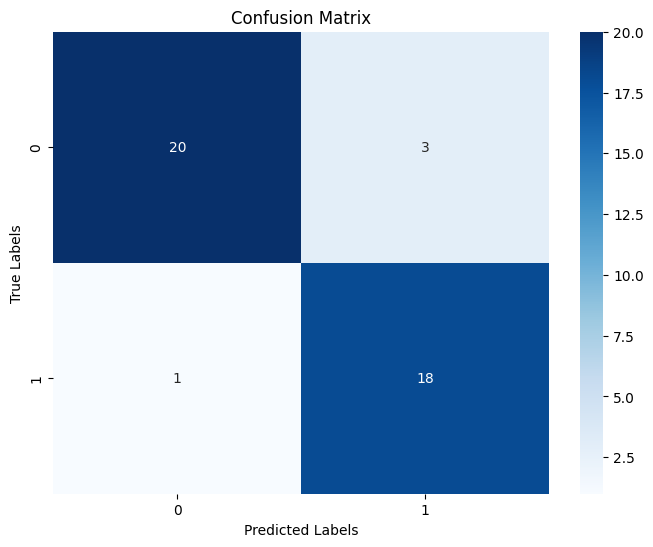

(1.0, 0.9047619047619048)

In [32]:
best_svm = svm_grid_search(X_train, y_train)
evaluate_svm(best_svm, X_train, y_train, X_test, y_test)